In [1]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from collections import deque
from scipy.stats import skew
import matplotlib.pyplot as plt  # Added for plotting
import seaborn as sns  # Added for enhanced visualizations
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [3]:
# Load and preprocess training data
data = pd.read_csv("iot_train_data.csv")
for col in ['light', 'motion']:
    if col in data.columns:
        data[col] = data[col].astype(int)
data["ts"] = pd.to_datetime(data["ts"], unit="s", errors="coerce")
data["hour"] = data["ts"].dt.hour
data["day_of_week"] = data["ts"].dt.dayofweek
data["elapsed_time"] = (data["ts"] - data["ts"].min()).dt.total_seconds()

sensor_columns = ["co", "humidity", "light", "lpg", "motion", "smoke", "temp"]
train_df = data.melt(id_vars=["ts", "device", "hour", "day_of_week", "elapsed_time"],
                     value_vars=sensor_columns, var_name="sensor_type", value_name="sensor_value")
train_df["sensor_value"] = pd.to_numeric(train_df["sensor_value"], errors="coerce")
train_df["is_boolean"] = train_df["sensor_value"].isin([0, 1]).astype(int)
train_df["value_magnitude"] = np.log10(train_df["sensor_value"].abs() + 1e-6)


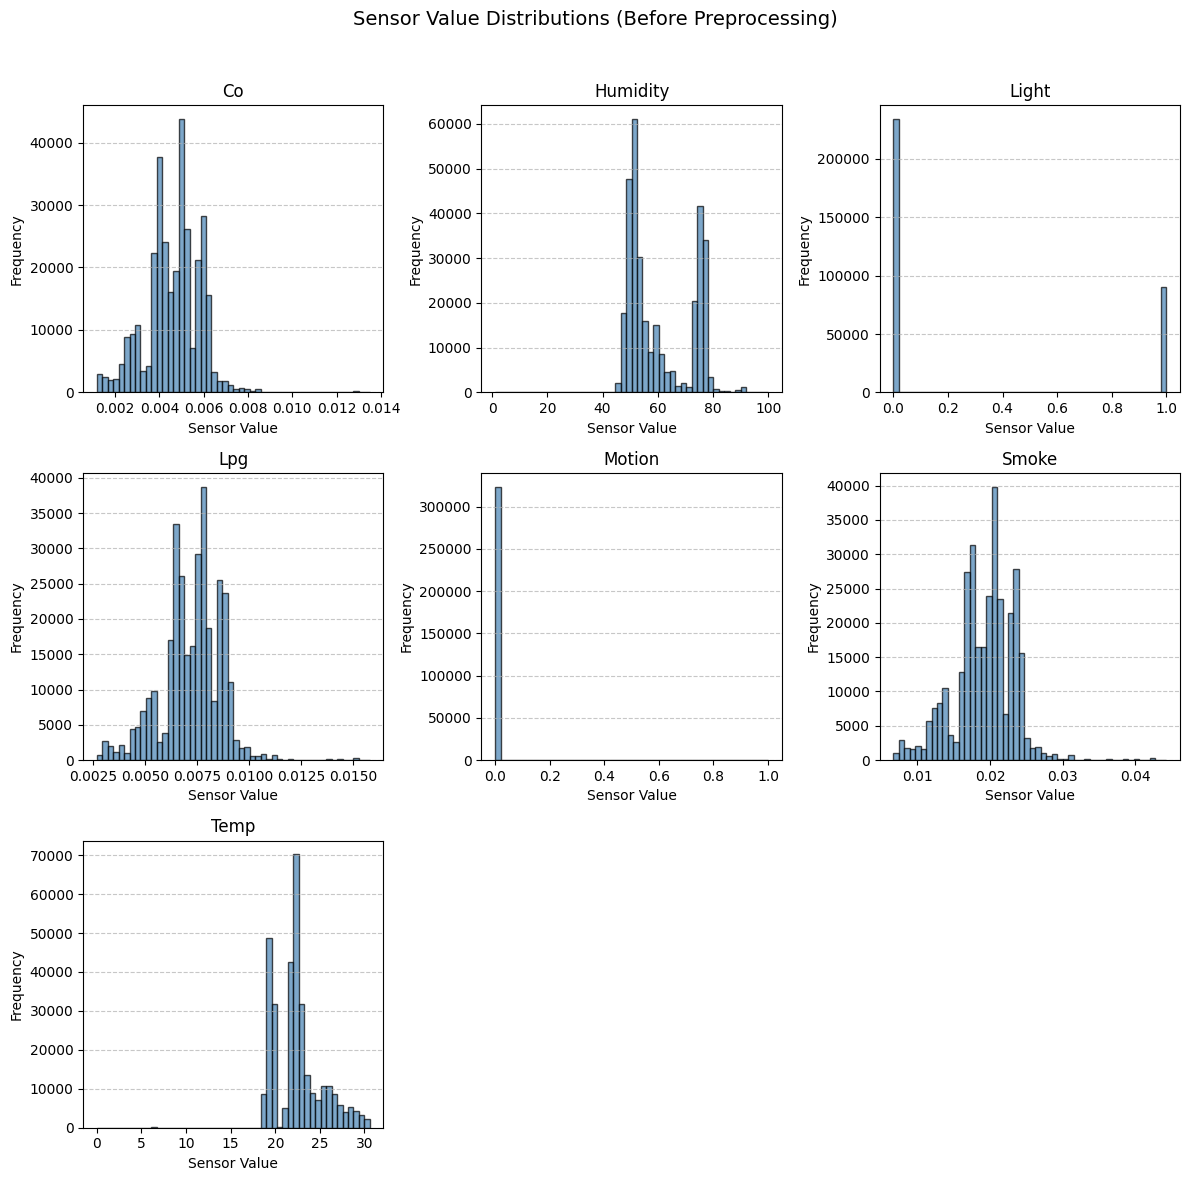

In [4]:
# Define the number of rows and columns for subplots
num_sensors = len(sensor_columns)
cols = 3  # Number of columns in the grid
rows = (num_sensors + cols - 1) // cols  # Compute required rows dynamically

# Create a single figure with multiple subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
fig.suptitle("Sensor Value Distributions (Before Preprocessing)", fontsize=14)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Iterate through sensor columns and plot in subplots
for i, sensor in enumerate(sensor_columns):
    axes[i].hist(data[sensor], bins=50, alpha=0.7, color="steelblue", edgecolor="black")
    axes[i].set_title(f"{sensor.capitalize()}")
    axes[i].set_xlabel("Sensor Value")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

# Remove empty subplots if the number of sensors is not a perfect multiple of `cols`
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit titles properly
plt.show()

In [6]:
# --- PLOT 1: Distribution of Sensor Values by Sensor Type ---
plt.figure(figsize=(12, 6))
sns.boxplot(x="sensor_type", y="sensor_value", data=train_df)
plt.title("Distribution of Sensor Values by Sensor Type")
plt.xticks(rotation=45)
plt.xlabel("Sensor Type")
plt.ylabel("Sensor Value")
plt.tight_layout()
plt.savefig("sensor_value_distribution.png")
plt.close()

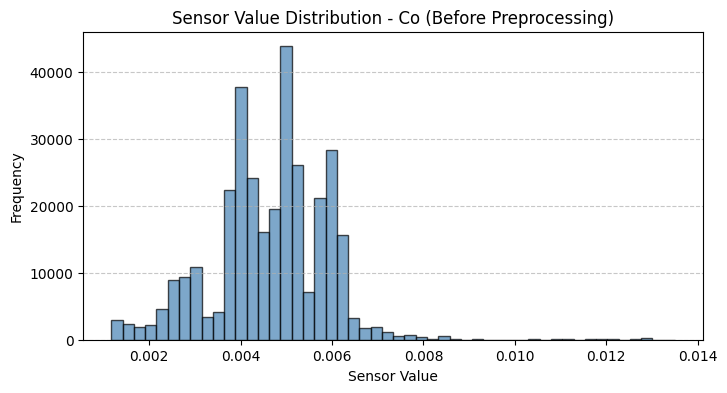

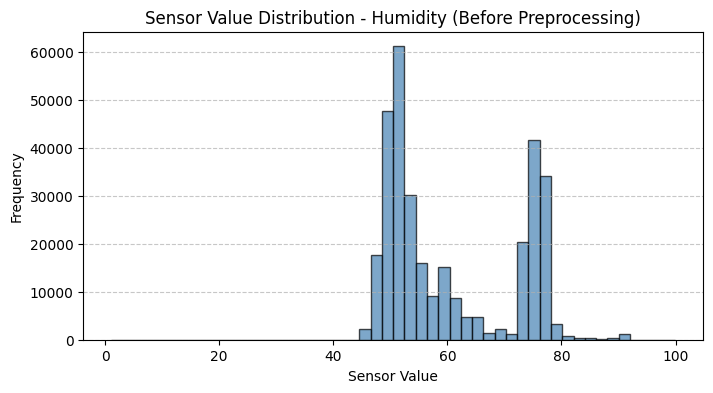

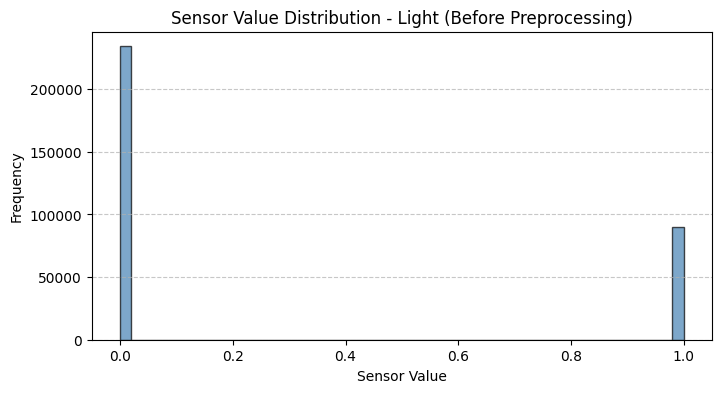

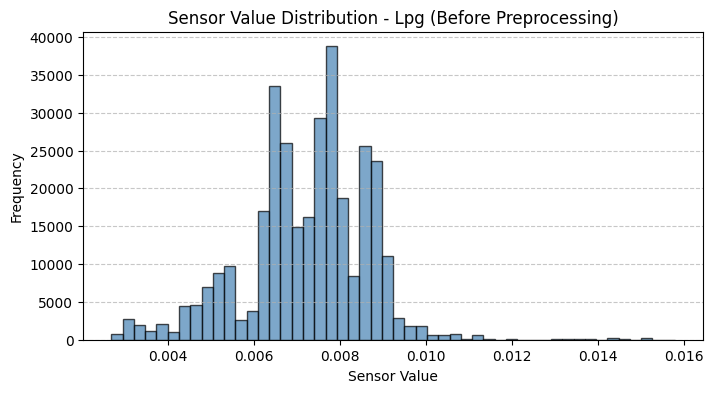

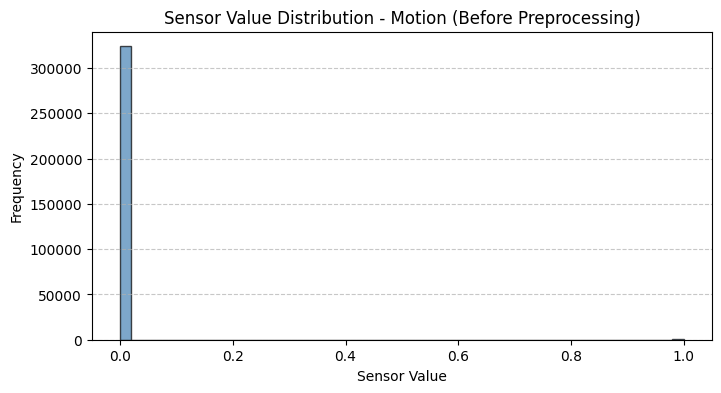

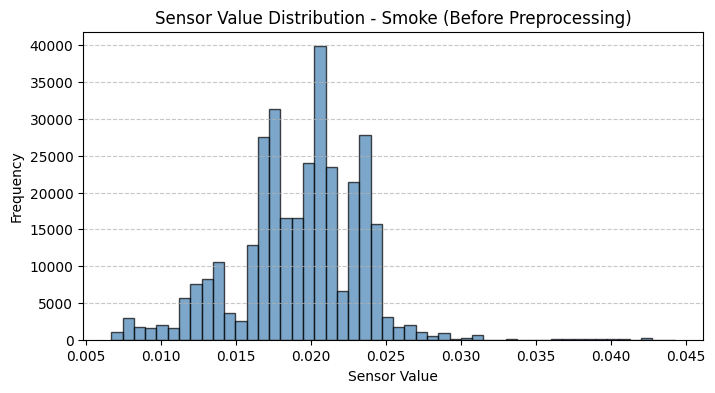

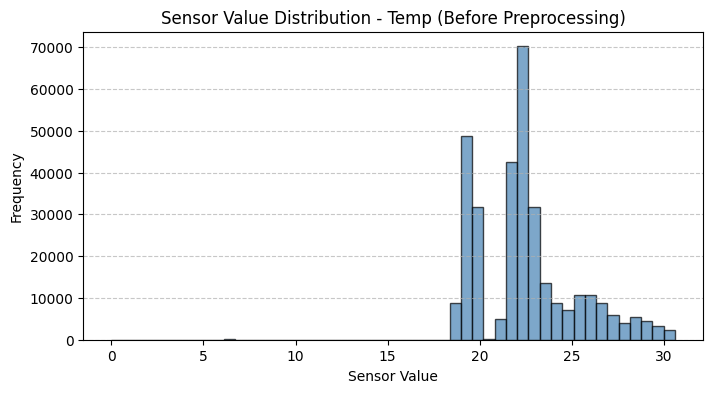

In [7]:
# 📌 Plot Each Sensor in a Separate Figure
for sensor in sensor_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(data[sensor], bins=50, alpha=0.7, color="steelblue", edgecolor="black")
    plt.title(f"Sensor Value Distribution - {sensor.capitalize()} (Before Preprocessing)")
    plt.xlabel("Sensor Value")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [25]:
# Feature engineering
def streaming_feature_engineering(df, window_size=10):
    df = df.copy()
    grouped = df.groupby("device")
    for name, group in grouped:
        window = deque(maxlen=window_size)
        means, medians, maxs, mins, stds, vars, ranges, skews, diffs = [], [], [], [], [], [], [], [], []
        prev_val = None
        for val in group["sensor_value"]:
            window.append(val)
            arr = np.array(window)
            means.append(np.mean(arr))
            medians.append(np.median(arr))
            maxs.append(np.max(arr))
            mins.append(np.min(arr))
            stds.append(np.std(arr) if len(arr) > 1 else 0)
            vars.append(np.var(arr) if len(arr) > 1 else 0)
            ranges.append(np.max(arr) - np.min(arr) if len(arr) > 1 else 0)
            skew_val = skew(arr) if len(arr) > 2 and np.var(arr) > 1e-6 else 0
            skews.append(skew_val)
            diffs.append(val - prev_val if prev_val is not None else 0)
            prev_val = val
        df.loc[group.index, "sensor_value_rolling_mean"] = means
        df.loc[group.index, "sensor_value_rolling_median"] = medians
        df.loc[group.index, "sensor_value_rolling_max"] = maxs
        df.loc[group.index, "sensor_value_rolling_min"] = mins
        df.loc[group.index, "sensor_value_rolling_std"] = stds
        df.loc[group.index, "sensor_value_rolling_variance"] = vars
        df.loc[group.index, "sensor_value_range"] = ranges
        df.loc[group.index, "sensor_value_skew"] = skews
        df.loc[group.index, "sensor_value_diff"] = diffs
        df["is_gas_range"] = df["sensor_value"].apply(lambda x: 1 if 0.001 <= abs(x) <= 0.05 else 0)
        df["is_temp_range"] = df["sensor_value"].apply(lambda x: 1 if 0 <= abs(x) <= 31 else 0)
        df["value_ratio"] = (df["sensor_value"] - df["sensor_value_rolling_mean"]) / (df["sensor_value_range"] + 1e-6)
        df["value_relative_to_max"] = df["sensor_value"] / (df["sensor_value_rolling_max"] + 1e-6)
    return df

train_df = streaming_feature_engineering(train_df)


In [9]:
# --- PLOT 2: Time Series of Sensor Values for a Sample Device ---
sample_device = train_df["device"].iloc[0]  # Pick first device as example
plt.figure(figsize=(14, 6))
sample_data = train_df[train_df["device"] == sample_device]
for sensor in sensor_columns:
    subset = sample_data[sample_data["sensor_type"] == sensor]
    plt.plot(subset["ts"], subset["sensor_value"], label=sensor)
plt.title(f"Sensor Values Over Time for Device: {sample_device}")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")
plt.legend()
plt.tight_layout()
plt.savefig("time_series_sample_device.png")
plt.close()

In [26]:
# Encode labels
encoder_sensor = LabelEncoder()
train_df["sensor_label"] = encoder_sensor.fit_transform(train_df["sensor_type"])
joblib.dump(encoder_sensor, "encoder_sensor.joblib")

['encoder_sensor.joblib']

In [27]:
# Define features
feature_columns = [
    "sensor_value", "sensor_value_rolling_mean", "sensor_value_rolling_median", "sensor_value_rolling_max",
    "sensor_value_rolling_min", "sensor_value_rolling_std", "sensor_value_rolling_variance", "sensor_value_range",
    "sensor_value_skew", "sensor_value_diff", "value_ratio", "value_relative_to_max", "hour", "day_of_week",
    "elapsed_time", "is_boolean", "value_magnitude", "is_gas_range", "is_temp_range"
]

# Scaling per sensor type
scalers, transformers = {}, {}
ranges = train_df.groupby("sensor_type")["sensor_value"].agg(['min', 'max']).to_dict('index')
print("Ranges after definition:", ranges)

Ranges after definition: {'co': {'min': 0.0011705085484379, 'max': 0.0144201053045069}, 'humidity': {'min': 1.100000023841858, 'max': 99.9000015258789}, 'light': {'min': 0.0, 'max': 1.0}, 'lpg': {'min': 0.0026934786226618, 'max': 0.0165673771625031}, 'motion': {'min': 0.0, 'max': 1.0}, 'smoke': {'min': 0.0066920963173865, 'max': 0.0465901156263079}, 'temp': {'min': 0.0, 'max': 30.600000381469727}}


In [28]:
for sensor in train_df["sensor_type"].unique():
    mask = train_df["sensor_type"] == sensor
    sensor_values = train_df.loc[mask, "sensor_value"]
    if sensor_values.nunique() == 2:
        scalers[sensor] = None
    elif sensor_values.skew() > 1.0:
        transformers[sensor] = FunctionTransformer(np.log1p, validate=True)
        train_df.loc[mask, "sensor_value"] = transformers[sensor].fit_transform(sensor_values.values.reshape(-1, 1))
    else:
        scalers[sensor] = MinMaxScaler()
        train_df.loc[mask, "sensor_value"] = scalers[sensor].fit_transform(sensor_values.values.reshape(-1, 1))
joblib.dump(scalers, "sensor_scalers.joblib")
joblib.dump(transformers, "sensor_transformers.joblib")

['sensor_transformers.joblib']

In [29]:
# Split data
X = train_df[feature_columns]
y = train_df["sensor_label"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Impute
imputer = SimpleImputer(strategy="mean")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=feature_columns)
joblib.dump(imputer, "imputer.joblib")

['imputer.joblib']

In [31]:
# Compute sample weights
class_counts = train_df["sensor_label"].value_counts()
max_count = max(class_counts)
gas_boost = 2.0
weights = np.array([max_count / class_counts[label] * (gas_boost if encoder_sensor.inverse_transform([label])[0] in ['co', 'lpg', 'smoke'] else 1) for label in y_train])

In [32]:
# Train LightGBM
lgbm_params = {
    "max_depth": 5, "learning_rate": 0.03, "num_leaves": 20, "lambda_l1": 7.0, "lambda_l2": 7.0,
    "feature_fraction": 0.7, "bagging_fraction": 0.7, "bagging_freq": 10, "objective": "multiclass",
    "num_class": len(encoder_sensor.classes_), "random_state": 42, "verbose": -1
}
train_data = lgb.Dataset(X_train, label=y_train, weight=weights)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
model = lgb.train(lgbm_params, train_data, valid_sets=[valid_data], num_boost_round=2000,
                  callbacks=[lgb.early_stopping(stopping_rounds=50)])
joblib.dump(model, "sensor_lgbm_classifier.joblib")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[727]	valid_0's multi_logloss: 0.166532


['sensor_lgbm_classifier.joblib']

In [33]:
# Make predictions on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred_classes)
precision = precision_score(y_val, y_pred_classes, average='weighted')
recall = recall_score(y_val, y_pred_classes, average='weighted')
f1 = f1_score(y_val, y_pred_classes, average='weighted')

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes, target_names=encoder_sensor.classes_))

# Print summary metrics
print(f"\nModel Performance on Validation Set:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision (weighted): {precision:.2%}")
print(f"Recall (weighted): {recall:.2%}")
print(f"F1-Score (weighted): {f1:.2%}")

# Optionally, save metrics to a file for your dissertation
with open("model_metrics.txt", "w") as f:
    f.write(f"Accuracy: {accuracy:.2%}\n")
    f.write(f"Precision (weighted): {precision:.2%}\n")
    f.write(f"Recall (weighted): {recall:.2%}\n")
    f.write(f"F1-Score (weighted): {f1:.2%}\n")


Classification Report:
              precision    recall  f1-score   support

          co       1.00      1.00      1.00     80924
    humidity       1.00      1.00      1.00     80815
       light       1.00      0.28      0.44     81209
         lpg       1.00      1.00      1.00     80785
      motion       0.58      1.00      0.73     80795
       smoke       1.00      1.00      1.00     81357
        temp       1.00      1.00      1.00     81373

    accuracy                           0.90    567258
   macro avg       0.94      0.90      0.88    567258
weighted avg       0.94      0.90      0.88    567258


Model Performance on Validation Set:
Accuracy: 89.70%
Precision (weighted): 94.01%
Recall (weighted): 89.70%
F1-Score (weighted): 88.18%


In [17]:
# --- PLOT 3: Feature Importance from LightGBM ---
plt.figure(figsize=(12, 6))
lgb.plot_importance(model, max_num_features=15, importance_type="gain")
plt.title("Top 15 Feature Importance (Gain)")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.close()

print("Model trained and saved successfully! Plots generated: sensor_value_distribution.png, time_series_sample_device.png, feature_importance.png")

Model trained and saved successfully! Plots generated: sensor_value_distribution.png, time_series_sample_device.png, feature_importance.png


<Figure size 1200x600 with 0 Axes>